In [1]:
# Run the command below if necessary, for example with Google Colab
#!pip3 install mxnet-cu110

In [2]:
# Global Libs
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
from sklearn import datasets, metrics

# Seeds for reproducibility
mx.random.seed(1)
np.random.seed(1)
random.seed(1)

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Local libs
import model

In [3]:
# Loading Iris dataset
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df.insert(0, "class", iris.target)

In [4]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   class              150 non-null    int64  
 1   sepal length (cm)  150 non-null    float64
 2   sepal width (cm)   150 non-null    float64
 3   petal length (cm)  150 non-null    float64
 4   petal width (cm)   150 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [5]:
iris_df.head()

,class,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0,5.1,3.5,1.4,0.2
1,0,4.9,3.0,1.4,0.2
2,0,4.7,3.2,1.3,0.2
3,0,4.6,3.1,1.5,0.2
4,0,5.0,3.6,1.4,0.2


In [6]:
# Dataset Split 50/40/10
from sklearn.model_selection import train_test_split

full_train_df, test_df = train_test_split(iris_df, test_size=0.1, random_state=42)

# To match correctly  10% size, we use previous size as reference
train_df, val_df = train_test_split(full_train_df, test_size=4*len(test_df), random_state=42)

In [7]:
train_df.groupby("class").size()

class
0    27
1    21
2    27
dtype: int64

In [8]:
val_df.groupby("class").size()

class
0    17
1    23
2    20
dtype: int64

In [9]:
test_df.groupby("class").size()

class
0    6
1    6
2    3
dtype: int64

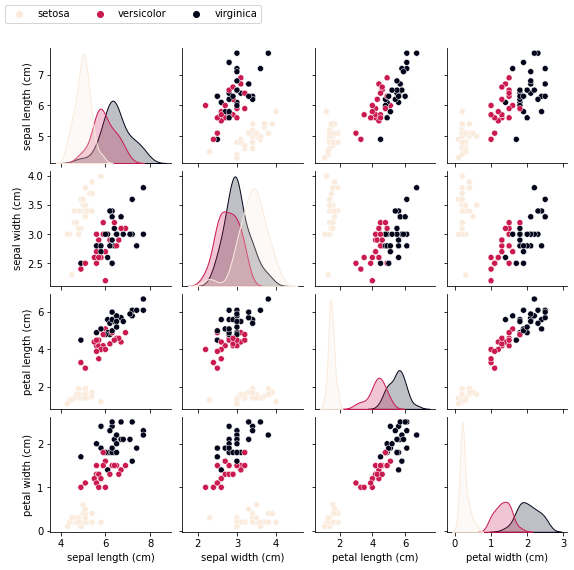

In [10]:
g = sns.pairplot(train_df, hue="class", height=2, palette="rocket_r")

handles = g._legend_data.values()
labels = list(iris.target_names)

g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

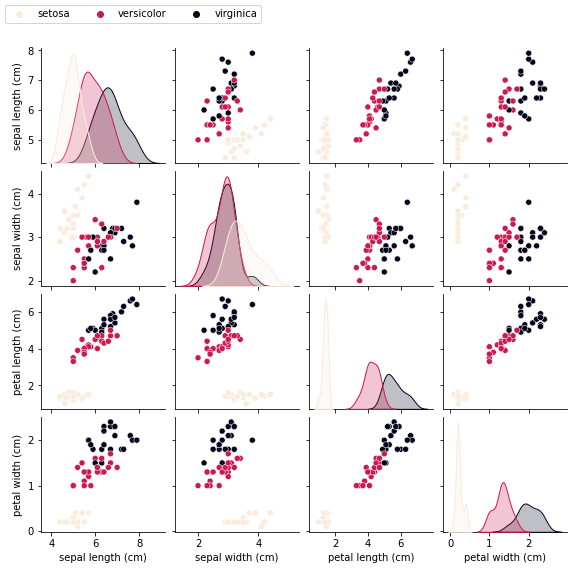

In [11]:
g = sns.pairplot(val_df, hue="class", height=2, palette="rocket_r")

handles = g._legend_data.values()
labels = list(iris.target_names)

g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

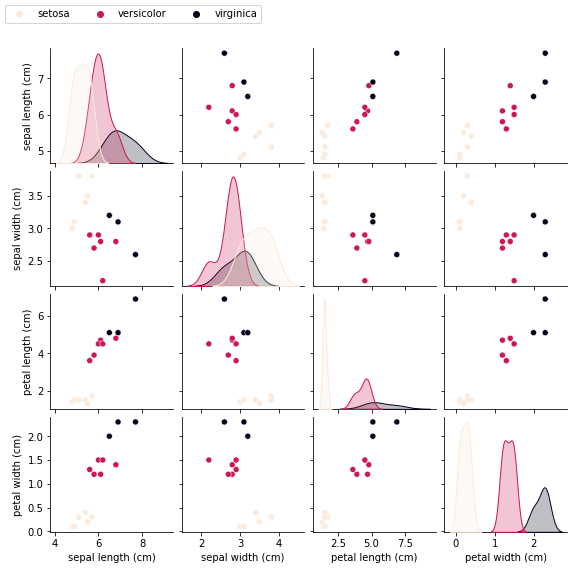

In [12]:
g = sns.pairplot(test_df, hue="class", height=2, palette="rocket_r")

handles = g._legend_data.values()
labels = list(iris.target_names)

g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

In [13]:
def scale_features(features, sc = None):
    """
    Applies Standard Scaling to X, y
    returns scaled version of X,y
    """
    if not sc:
        sc = StandardScaler()
    scaled_features = sc.fit_transform(features)
    return scaled_features, sc

In [14]:
# Data Preprocessing Training set

# Step 2: Feature Scaling for Training, Validation and Testing
X_train = np.array(train_df.drop(["class"], axis=1).to_numpy(), dtype=np.float32)
y_train = np.array(train_df["class"].to_numpy().reshape(-1,1), dtype=np.uint8)
X_val   = np.array(val_df.drop(["class"], axis=1).to_numpy(), dtype=np.float32)
y_val   = np.array(val_df["class"].to_numpy().reshape(-1,1), dtype=np.uint8)
X_test  = np.array(test_df.drop(["class"], axis=1).to_numpy(), dtype=np.float32)
y_test  = np.array(test_df["class"].to_numpy().reshape(-1,1), dtype=np.uint8)

scaled_X_train, sc_X = scale_features(X_train)
scaled_X_val, _ = scale_features(X_val, sc_X)
scaled_X_test, _ = scale_features(X_test, sc_X)

In [15]:
# Saving data to analyse further
with open("data_classification.pkl", "wb") as f:
    pickle.dump([X_train, y_train, X_val, y_val, X_test, y_test], f)

with open("scaled_data_classification.pkl", "wb") as f:
    pickle.dump([scaled_X_train, scaled_X_val, scaled_X_test], f)

In [16]:
# Prepare datasets to work with DataLoader
training_set = mx.gluon.data.dataset.ArrayDataset(scaled_X_train, y_train)
validation_set = mx.gluon.data.dataset.ArrayDataset(scaled_X_val, y_val)

scaled_example_input = mx.nd.array([scaled_X_train[0]])

In [17]:
net = model.create_classification_network()

In [18]:
# Initialization

# We need to set the context of the data, GPU in this case
# Swap comments in the next 2 lines for CPU
ctx = mx.gpu()
# ctx = mx.cpu()

net.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx, force_reinit=True)

[20:32:44] ../src/base.cc:80: cuDNN lib mismatch: linked-against version 8101 != compiled-against version 8100.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


In [20]:
# Calculate number of trainable parameters
net.summary(scaled_example_input.as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                                      (1, 4)               0
        Activation-1                                     (1, 10)               0
             Dense-2                                     (1, 10)              50
        Activation-3                                     (1, 10)               0
             Dense-4                                     (1, 10)             110
             Dense-5                                      (1, 3)              33
Parameters in forward computation graph, duplicate included
   Total params: 193
   Trainable params: 193
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique parameters in model: 193
--------------------------------------------------------------------------------


In [66]:
# Training Loop, saving best model
model_file_name = "classification_net.params"

def training_loop(loss_fn, trainer, epochs, batch_size, training_set, validation_set, ctx = mx.gpu()):
    max_val_acc = 0
    
    # Returned values (use-case: plotting losses & validation)
    training_loss, validation_loss, validation_acc = [], [], []
    
    # Iterator for Gluon data access
    training_data_iterator = mx.gluon.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    validation_data_iterator = mx.gluon.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    
    num_training_batches = len(training_set) / batch_size
    num_validation_batches = len(validation_set) / batch_size
    
    for e in range(epochs):
                
        cumulative_loss = 0
        # inner loop
        for data, label in training_data_iterator:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with mx.autograd.record():
                output = net(data)
                loss = loss_fn(output, label)
            loss.backward()
            trainer.step(batch_size)
            current_loss = mx.nd.mean(loss).asscalar()
            cumulative_loss += current_loss / num_training_batches
        
        # Validation Loss & Accuracy
        cumulative_val_loss = 0
        # Validation Accuracy Metric (using MXNet)
        acc = mx.metric.Accuracy()
        
        for data, label in validation_data_iterator:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            output = net(data)
            val_loss = loss_fn(output, label)
            current_val_loss = mx.nd.mean(val_loss).asscalar()
            cumulative_val_loss += current_val_loss / num_validation_batches
            
            # Accuracy
            acc.update([label], [output])
        
        acc_value = acc.get()[1]
        validation_acc.append(acc_value)
        
        added_info = ""
        if acc_value > max_val_acc:
            added_info = " --- Updating saved model"
            max_val_acc = acc_value
            net.save_parameters(model_file_name)
            
        desc = f"E: {e:4d}, TrL: {cumulative_loss:8.6f}, VL: {cumulative_val_loss:8.6f}, VAcc: {acc_value:8.6f}" + added_info
        print(desc)
        
        # Saving loss values
        training_loss.append(cumulative_loss)
        validation_loss.append(cumulative_val_loss)
        
    return training_loss, validation_loss, validation_acc

In [67]:
# Define Loss Function
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(net.collect_params(), "adam", {"learning_rate": 0.01})
#trainer = mx.gluon.Trainer(net.collect_params(), "sgd", {"learning_rate": 3.0})

# Epochs & Batch Size
# Optimal values: "adam", lr: 0.01, 100 epochs, batch size 32
epochs = 300
batch_size = 32

net.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx, force_reinit=True)

training_loss, validation_loss, validation_acc = training_loop(loss_fn, trainer, epochs, batch_size, training_set, validation_set, ctx)

E:    0, TrL: 0.885081, VL: 0.585522, VAcc: 0.716667 --- Updating saved model
E:    1, TrL: 0.586625, VL: 0.488587, VAcc: 0.850000 --- Updating saved model
E:    2, TrL: 0.493357, VL: 0.427792, VAcc: 0.933333 --- Updating saved model
E:    3, TrL: 0.386693, VL: 0.389380, VAcc: 0.916667
E:    4, TrL: 0.378050, VL: 0.355815, VAcc: 0.916667
E:    5, TrL: 0.362584, VL: 0.335178, VAcc: 0.933333
E:    6, TrL: 0.315710, VL: 0.315903, VAcc: 0.916667
E:    7, TrL: 0.313542, VL: 0.297193, VAcc: 0.916667
E:    8, TrL: 0.248777, VL: 0.277012, VAcc: 0.933333
E:    9, TrL: 0.258154, VL: 0.258605, VAcc: 0.933333
E:   10, TrL: 0.206237, VL: 0.239942, VAcc: 0.933333
E:   11, TrL: 0.244119, VL: 0.224674, VAcc: 0.933333
E:   12, TrL: 0.215215, VL: 0.210938, VAcc: 0.933333
E:   13, TrL: 0.195642, VL: 0.197390, VAcc: 0.933333
E:   14, TrL: 0.210344, VL: 0.186618, VAcc: 0.950000 --- Updating saved model
E:   15, TrL: 0.194954, VL: 0.176020, VAcc: 0.950000
E:   16, TrL: 0.163580, VL: 0.167597, VAcc: 0.950000

E:  159, TrL: 0.011666, VL: 0.088070, VAcc: 0.950000
E:  160, TrL: 0.023748, VL: 0.087469, VAcc: 0.950000
E:  161, TrL: 0.021732, VL: 0.094389, VAcc: 0.950000
E:  162, TrL: 0.011537, VL: 0.089809, VAcc: 0.950000
E:  163, TrL: 0.010784, VL: 0.082940, VAcc: 0.950000
E:  164, TrL: 0.011519, VL: 0.082461, VAcc: 0.950000
E:  165, TrL: 0.010025, VL: 0.085003, VAcc: 0.950000
E:  166, TrL: 0.021859, VL: 0.087465, VAcc: 0.950000
E:  167, TrL: 0.011149, VL: 0.087301, VAcc: 0.950000
E:  168, TrL: 0.009441, VL: 0.086923, VAcc: 0.950000
E:  169, TrL: 0.013562, VL: 0.088925, VAcc: 0.950000
E:  170, TrL: 0.010952, VL: 0.087872, VAcc: 0.950000
E:  171, TrL: 0.011524, VL: 0.091256, VAcc: 0.950000
E:  172, TrL: 0.009130, VL: 0.090524, VAcc: 0.950000
E:  173, TrL: 0.011344, VL: 0.089470, VAcc: 0.950000
E:  174, TrL: 0.010472, VL: 0.084797, VAcc: 0.950000
E:  175, TrL: 0.012812, VL: 0.086837, VAcc: 0.950000
E:  176, TrL: 0.009128, VL: 0.089587, VAcc: 0.950000
E:  177, TrL: 0.009153, VL: 0.091471, VAcc: 0.

In [69]:
# Saving losses to analyse further
with open("classification_losses_adam.pkl", "wb") as f:
    pickle.dump([training_loss, validation_loss, validation_acc], f)